# Talbe of contents

* [Introduction](#introduction)
* [Import libraries](#importlibraries)
* [Task 1: Data Integration](#task_1)
    * [Step 01: Find the suburb](#step01)
    * [Step 02: Find the closest train station id and distance(m)](#step02)
    * [Step 03: Calculate the average travel time from the closest train station to Southern Cross Station](#step03)
    * [Step 04: over priced?](#step04)
    * [Step 05: crime A/B/C average](#step05)
    * [Step 06: Find the closest primary/ Secondary school and the distance(m) between property](#step06)
    * [Step 07: Primary / Secondary School Ranking](#step07)

* [Taks 2: Data reshaping](#task_2)

* [Summary](#summary)

# Introduction
<a id="introduction"></a>

Here are two main targets in this assignment. 

First is to integrate several datasets into one single schema and input some data and fix possible problems in this final data.

Second is to find which attributes( Rooms, crime_C_average,travel_min_to_CBD, and property_age) is important to predict the price when we want to build a linear model. In addition, in this part we will use different normalization/ transformation metods, such as standardization, min-max normalization, log, power, and root transformation on attributes to observe and explore the effect on the linear model we want to build.



# Import libraries
<a id="importlibraries"></a>
Import some libraries for this assignment:
* pandas
* re 
* numpy 
* sklearn
* BeautifulSoup
* geopandas
* pygtfs
* shapely
* math
* datetime
* urllib
* difflib
* zipfile

In [69]:
#!pip install pandas
#!pip install bs4
#!pip install geopandas
#!pip install pygtfs
import pygtfs
from bs4 import BeautifulSoup as bsoup
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Point
import fiona
from math import *
import numpy as np
from datetime import datetime, timedelta
from urllib.request import urlopen
import re
import difflib
from zipfile import ZipFile
import os
import sys 
from sklearn import preprocessing
from matplotlib import pyplot as plt
import statsmodels.formula.api as sm
import math

# Task 1: Data Integration
<a id="task_1"></a>
In this task, integrate some datasets into on with the following schema.

In [2]:
#read the csv file
df = pd.read_csv("Group081.csv")

## Find the suburb
<a id="step01"></a>

The target in this step is to find the property in which suburb.

We use the Vic_suburb_boundary.zip file to set the suburb boundary, and if the property's lattitude and longtitude are included in the suburb's lattitude and longtitude, we fill the suburb for this property.

In [3]:
# Extract the zip file of vic_suburb_boundary.zip
zip_boundary = ZipFile('vic_suburb_boundary.zip')
zip_boundary.extractall()

In [4]:
# open the VIC_LOCALITY_POLYGON_shp.shp by using fiona libary
collection = fiona.open('VIC_LOCALITY_POLYGON_shp.shp')

shapes = {}
townnames = {}
for f in collection:
    # the surburb id
    town_id = f['properties']['LC_PLY_PID']  
    # the lattitude and longtitude boundary of surburb
    shapes[town_id] = shape(f['geometry']) 
    # the surburb name
    townnames[town_id] =f['properties']['VIC_LOCA_2']
    
def search(lat, long):  
    global shapes, townnames
    #if the lattitude and longtitude are included in the suburb's lattitude and longtitude, return suburb name.
    return next((townnames[town_id]  for town_id in shapes if shapes[town_id].contains(Point(lat, long))), None)

In [5]:
# apply the search hunction to the df
df['Suburb']=df.apply(lambda x: search(x.Longtitude, x.Lattitude),axis=1)

## Find the train station id and station distance (m)
<a id="step02"></a>
The target in this part is to find the closest train staion to the property which has a direct trip to the Southern Cross Railway Station and the direct distance from the closest train station to the property.

In this section, we first extract gtfs file to find the stations and trips data, and then create get distance function to calculate the distance from the property to the cloest train station.



In [6]:
#Extract the gtfs file
zip_gtfs = ZipFile('gtfs.zip')
zip_gtfs.extractall()

In [7]:
# create a schedule object (a sqlite database)
sched = pygtfs.Schedule(":memory:")                
# append data to schedule object
pygtfs.append_feed(sched, "./1/google_transit.zip")
pygtfs.append_feed(sched, "./2/google_transit.zip")

Loading GTFS data for <class 'pygtfs.gtfs_entities.Agency'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Stop'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Route'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Trip'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.StopTime'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Service'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.ServiceException'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Fare'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.FareRule'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.ShapePoint'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Frequency'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Transfer'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.FeedInfo'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Translation'>:
1 record read for <class 'pygtfs.gtfs_entities.Agency'>.
109 records read for <class 'pygtfs.gtfs_entities.Stop'>.
188 rec

#### In this step, we find the station name and station's Longtitude and Lattitude.

In [8]:
# get the query of trips in schedule
sched_trips=sched.trips_query
# get the query of services in schedule
sched_services=sched.services_query
# get the query of stops in schedule
sched_stops=sched.stops_query
# get the query of stop_times in schedule
sched_stop_time=sched.stop_times_query.all()



#stops={}
stops_id=[]
station_name=[]
station_lat_lon=[]

# for loop in the query of stops
for i in sched_stops.all():
    stop_id=i.stop_id
    stop_name=i.stop_name
    stop_lat=i.stop_lat
    stop_lon=i.stop_lon
    #stops[stop_id]={'stop_name':stop_name,'stop_lat':stop_lat,'stop_lon':stop_lon}
    lat_lon=[stop_lat,stop_lon]
    #append stop name to station_name list
    
    if stop_id not in stops_id:
        station_name.append(stop_name)
        #append lat and long to lat_lon list
        station_lat_lon.append(lat_lon)
        #append stop id to stop_id list
        stops_id.append(stop_id)

# translate the list of station_lat_lon to matrix
station_lat_lon_mat=np.matrix(station_lat_lon)   
    

#### In this step, we find the service ids that are work in weekday.

In [9]:
# get the query of services in schedule
sched_service=sched.services_query.all()
weekday_service_id=[]

#for loop in sched_service
for i in sched_service:
    service_id=i.service_id
    M=int(i.monday)
    T=int(i.tuesday)
    W=int(i.wednesday)
    Th=int(i.thursday)
    F=int(i.friday)
    
    #if M+T+W+Th+F >=1, append service_id to weekday_service_id
    if M+T+W+Th+F == 5 and service_id not in weekday_service_id:
        weekday_service_id.append(service_id)

#### In this step, we filter trips that are work in weekday.

In [10]:
weekday_trip=[]
#for loop in the query of services in schedule
for i in sched_trips.all():
    route_id=i.route_id
    service_id=i.service_id
    trip_id=i.trip_id
    #if service_id in weekday_service_id, append trip_id to weekday_trip
    if service_id in weekday_service_id:
        weekday_trip.append(trip_id)

#### In this step, we find trips that are work in weekday and departrue time between 8:00 am to 9:30am and combine with the station id.

In [11]:
southern_cross_stop_id=['20043','22180']
# set a dictionary to store the trip and stop station id
trip_stop={}

# for loop in the query of stop_time
for i in sched_stop_time:
    stop_list=[]
    stop_id=i.stop_id
    trip_id=i.trip_id
    # append stop_id to stop_list
    stop_list.append(stop_id)
    arrival_time=i.arrival_time
    departure_time=i.departure_time
    # if departure_time between '7:00:00' and '9:30:00', trip_id in trip_list, stop_id equals to station_id, append departure_time to departure_time_list
    if str(departure_time) >= '7:00:00' and str(departure_time) < '9:30:00' and trip_id in weekday_trip: 
        if trip_id not in trip_stop.keys():
            trip_stop[trip_id]=stop_list
        else:
            original_value=trip_stop[trip_id]
            original_value.append(stop_id)
            trip_stop[trip_id]=original_value
    # if trip_id in trip_stop.keys and if stop_id equals to southern_corss_stop_id, add the value to trip_stop[trip_id]
    elif trip_id in trip_stop.keys():
        if stop_id == southern_cross_stop_id[0]:
            original_value=trip_stop[trip_id]
            original_value.append(southern_cross_stop_id[0])
            trip_stop[trip_id]=original_value
        elif stop_id == southern_cross_stop_id[1]:
            original_value=trip_stop[trip_id]
            original_value.append(southern_cross_stop_id[1])
            trip_stop[trip_id]=original_value
            

#### Create the get_distance function that calculate the distance between property and station.

In [12]:
def get_distance(target,house):
    # radius of equator: KM
    ra = 6378  
    
    # change angle to radians
    target_rad_lat = np.radians(target[:,0])
    target_rad_lon = np.radians(target[:,1])
    house_rad_lat = np.radians(house[:,0])
    house_rad_lon = np.radians(house[:,1])
    
    dlon = house_rad_lon - target_rad_lon
    dlat = house_rad_lat - target_rad_lat
    a=np.power((np.sin(dlat/2)),2)+ np.multiply(np.multiply(np.cos(target_rad_lat),np.cos(house_rad_lat)),np.power((np.sin(dlon/2.0)),2))
    c = 2 * np.arcsin(np.sqrt(a))
    distance = ra * c *1000
    
    return distance

#### Create the find_station function to find the closest station and the distance between this station.

In [13]:
def find_station_name(lat,lon):
    Find_loc = np.matrix([[lat,lon]])
    #run get_distance function to get all distance between station.
    all_distance = get_distance(station_lat_lon_mat,Find_loc)
    #list 100 lowest distance
    rank_100=list(all_distance.argsort(axis=0)[:100])
    #for loop in rank_100
    for i in rank_100:
        # if station id equals to southern_cross_stop_id, return southern_cross_stop_id, and break the function
        if stops_id[int(i)] == southern_cross_stop_id[0]:
            return southern_cross_stop_id[0]
            break
        elif stops_id[int(i)] == southern_cross_stop_id[1]:
            return southern_cross_stop_id[1]
            break
            
        else:
            #for loop in the values in the dictionary of trip_stop 
            for j in trip_stop.values(): 
                # if target station id and southern_corss_station id all in trip, return station name and distance
                if stops_id[int(i)] in j and southern_cross_stop_id[0] in j and j.index(stops_id[int(i)]) < j.index(southern_cross_stop_id[0]):
                    station=stops_id[int(i)]
                    distance=round(float(all_distance[int(i)]),3)
                    return station
                    break
                elif stops_id[int(i)] in j and southern_cross_stop_id[1] in j and j.index(stops_id[int(i)]) < j.index(southern_cross_stop_id[1]):
                    station=stops_id[int(i)]
                    distance=round(float(all_distance[int(i)]),3)
                    return station
                    break

#### Create the find_station function to find the closest station and the distance between this station.

In [14]:
def find_station_distance(lat,lon):
    Find_loc = np.matrix([[lat,lon]])
    #run get_distance function to get all distance between station.
    all_distance = get_distance(station_lat_lon_mat,Find_loc)
    #list 500 lowest distance
    rank_10=list(all_distance.argsort(axis=0)[:100])
    for i in rank_10:
        for j in trip_stop.values(): 
            # if target station id and southern_corss_station id all in trip, return station name and distance
            if stops_id[int(i)] in j and (southern_cross_stop_id[0] in j or southern_cross_stop_id[1] in j):
                station=stops_id[int(i)]
                distance=round(float(all_distance[int(i)]),3)
                return distance
                break

In [15]:
# apply the find_station_name function to df
df['train_station_id']=df.apply(lambda x: find_station_name(x.Lattitude, x.Longtitude),axis=1)
# apply the find_station_distance function to df
df['distance_to_train_station']=df.apply(lambda x: find_station_distance(x.Lattitude, x.Longtitude),axis=1)

## travel_min_to_CBD
<a id="step03"></a>

In this target, we will find the average travel time(minutes) from the closest train station to the Southern Cross Railway Station on weekdays.


#### Create the average_min function to calcualte the average travel time(minutes) from the closest train station to the Southern Cross Railway Station on weekdays

In [16]:
def average_min(station_id):
    station_id=station_id
    if station_id not in southern_cross_stop_id:
        trip_list=[]
        #for loop in trip_stop dictionary
        for key,values in trip_stop.items():
            # if station_id and southern_cross_stop_id all in values, key in weekday_trip,and the index of station_id less than southern_cross_stop_id in values, append key to trip_list
            if station_id in values and southern_cross_stop_id[0] in values and values.index(station_id)<values.index(southern_cross_stop_id[0]):
                if key in weekday_trip:
                    trip_list.append(key)
            # if station_id and southern_cross_stop_id all in values, key in weekday_trip,and the index of station_id less than southern_cross_stop_id in values, append key to trip_list
            elif station_id in values and southern_cross_stop_id[1] in values and values.index(station_id)<values.index(southern_cross_stop_id[1]):
                if key in weekday_trip:
                    trip_list.append(key)
    
    
        departure_time_list=[]
        arrival_time_list=[]
    
        #for loop in sched_stop_time
        for i in sched_stop_time:
            stop_id=i.stop_id
            trip_id=i.trip_id
            arrival_time=i.arrival_time
            departure_time=i.departure_time
            # if trip_id in trip_list, stop_id equals to station_id, append departure_time to departure_time_list
            if trip_id in trip_list and stop_id == station_id: 
                departure_time_list.append(departure_time)
            #if trip_id in trip_list and stop_id equals to southern_cross_stop_id, append arrival_time to arrival_time_list
            if trip_id in trip_list and stop_id in southern_cross_stop_id: 
                arrival_time_list.append(arrival_time)
            
        #calculate the average by minus arrival_time and departure_time
        sum_second=0
        count=0
        for i in range(len(arrival_time_list)):
            sum_second+=(arrival_time_list[i]-departure_time_list[i]).seconds
            count+=1

        average_min=(sum_second/60)/count
    
    #if the station_id is equals to southern cross station, the average_min equals to zero
    else:
        average_min=0
    
    #return average_min
    return average_min


In [17]:
df['travel_min_to_CBD']=df.apply(lambda x: average_min(x.train_station_id),axis=1)

## over priced?
<a id="step04"></a>
In this step, we will find the boolean feature that whether or not the price of the property is higher than the median price of similar properties( with same bedrooms, batheroom, parking_space, and property_type) in the same suburb on the year of selling.


In [18]:
df['Year'] = df.apply(lambda x: x.Date[-4:], axis=1) # append a new column which stands for the year of selling.

In [19]:
# create a list storing columns used to check similarity
similar_list = ['Year',
                'Rooms',
                'Type',
                'Bathroom',
                'Car',
                'Suburb']

# get mean
df_mean = df.groupby(similar_list).mean()

# get count
df_count = df.groupby(similar_list).count()

#### define a function to get key for df_mean and df_count

In [20]:
def get_key(x):
    key = (x.Year, x.Rooms, x.Type, x.Bathroom, x.Car, x.Suburb)
    return key

# create a new column named 'over_priced', and if there is no any similar property
df['over_priced?'] = df.apply(lambda x: x.Price > df_mean.loc[get_key(x)].Price,
                              axis=1)

#### open councils.txt and create a dictionary which takes suburbs as keys and local government area as values

In [21]:
with open('councils.txt') as councils:
    sub_dict = {}
    
    for line in councils:
        # spilt line to a list
        line_list = line.strip().split(' :')
        
        # area means the loval government area
        area = line_list[0]
        
        # transform the suburbs string into a list
        sub_list = re.findall(r'\'(.*?)\'', line_list[1])
        
        # add new items into the dictionary
        for suburb in sub_list:
            sub_dict[suburb.upper()] = area

## Crime A/B/C average
<a id="step05"></a>

In this step, we calculate the average of type A/B/C crime in the local government area that the property belongs to , in the three years prior to selling the property as the property.

In [22]:
# open crimebylocationdatatable-yearending31march2016.xlsx, starts from 20th row
xl = pd.read_excel('crimebylocationdatatable-yearending31march2016.xlsx',
                   sheet_name='Table 1',
                   skiprows=19)

# drop an useless column
crime = xl.drop(columns='Unnamed: 0')

In [23]:
# group by year, crime type and government area and get summary of each group
crime_sum = crime.groupby(['Apr - Mar reference period',
                           'CSA Offence Division',
                           'Local Government Area']).sum()

#### define functions to get the average of crimes in the three years prior to selling the property.

In [24]:
def get_A(x):
    
    # check if the key is in the crime_sum
    if (int(x.Year)-1, 'A Crimes against the person', sub_dict[x.Suburb]) in crime_sum.index\
    and (int(x.Year)-2, 'A Crimes against the person', sub_dict[x.Suburb]) in crime_sum.index\
    and (int(x.Year)-3, 'A Crimes against the person', sub_dict[x.Suburb]) in crime_sum.index:
        
        # get the summary of three years
        # keys are year, crime type and government area
        sum = \
        crime_sum.loc[(int(x.Year)-1, 'A Crimes against the person', sub_dict[x.Suburb])]['Offence Count'] +\
        crime_sum.loc[(int(x.Year)-2, 'A Crimes against the person', sub_dict[x.Suburb])]['Offence Count'] +\
        crime_sum.loc[(int(x.Year)-3, 'A Crimes against the person', sub_dict[x.Suburb])]['Offence Count']
        
        # get the average
        avg = sum/3
        
    # if the year of selling is earlier than 2015, set it to default value: -1 
    else:
        avg = -1
    return avg

In [25]:
def get_B(x):
    if (int(x.Year)-1, 'B Property and deception offences', sub_dict[x.Suburb]) in crime_sum.index\
    and (int(x.Year)-2, 'B Property and deception offences', sub_dict[x.Suburb]) in crime_sum.index\
    and (int(x.Year)-3, 'B Property and deception offences', sub_dict[x.Suburb]) in crime_sum.index:
        sum = \
        crime_sum.loc[(int(x.Year)-1, 'B Property and deception offences', sub_dict[x.Suburb])]['Offence Count'] +\
        crime_sum.loc[(int(x.Year)-2, 'B Property and deception offences', sub_dict[x.Suburb])]['Offence Count'] +\
        crime_sum.loc[(int(x.Year)-3, 'B Property and deception offences', sub_dict[x.Suburb])]['Offence Count']
        avg = sum/3
    else:
        avg = -1
    return avg

In [26]:
def get_C(x):
    if (int(x.Year)-1, 'C Drug offences', sub_dict[x.Suburb]) in crime_sum.index\
    and (int(x.Year)-2, 'C Drug offences', sub_dict[x.Suburb]) in crime_sum.index\
    and (int(x.Year)-3, 'C Drug offences', sub_dict[x.Suburb]) in crime_sum.index:
        sum = \
        crime_sum.loc[(int(x.Year)-1, 'C Drug offences', sub_dict[x.Suburb])]['Offence Count'] +\
        crime_sum.loc[(int(x.Year)-2, 'C Drug offences', sub_dict[x.Suburb])]['Offence Count'] +\
        crime_sum.loc[(int(x.Year)-3, 'C Drug offences', sub_dict[x.Suburb])]['Offence Count']
        avg = sum/3
    else:
        avg = -1
    return avg

In [27]:
# apply functions for each crime type
df['crime_A_average'] = df.apply(lambda x: get_A(x), axis=1)
df['crime_B_average'] = df.apply(lambda x: get_B(x), axis=1)
df['crime_C_average'] = df.apply(lambda x: get_C(x), axis=1)

In [28]:
df = df.drop(columns='Year')

## Find the closest primary/ Secondary school and the distance (m) between property
<a id="step06"></a>

In this section, we find the colos the closest primary school to the property. In addition, we will calculate the direct distance between the property and the closest primary school.

We will use bsoup to parse the xml file and extract the data we need, and then use get_distance function to calculate the distance.

In [29]:
# use bsoup to open the schools.xml file
soup = bsoup(open('schools.xml'),"lxml-xml")
school_name_list=[]
p_school_list=[]
p_school_lat_lon=[]

s_school_list=[]
s_school_lat_lon=[]

# for loop in soup.find_all('school')
for i in soup.find_all('school'):
        School_name=i.find("School_Name").string 
        Education_Sector=i.find("Education_Sector").string 
        Entity_Type=i.find("Entity_Type").string 
        School_No=i.find("School_No").string 
        School_Type=i.find("School_Type").string 
        Full_Phone_No=i.find("Full_Phone_No").string 
        LGA_ID=i.find("LGA_ID").string 
        LGA_Name=i.find("LGA_Name").string 
        X=float(i.find("X").string)
        Y=float(i.find("Y").string)
        school_name_list.append(School_name)
        #if school_type equals to 'Primary' or 'Pri/Sec', append school_name to p_school_list and append lat_lon to p_school_lat_lon
        if School_Type == 'Primary' or School_Type == 'Pri/Sec':
            p_school_list.append(School_name)
            lat_lon=[Y,X]
            p_school_lat_lon.append(lat_lon)
        #if school_type equals to 'Secondary' or 'Pri/Sec', append school_name to s_school_list and append lat_lon to s_school_lat_lon
        if School_Type == 'Secondary' or School_Type == 'Pri/Sec':
            s_school_list.append(School_name)
            lat_lon=[Y,X]
            s_school_lat_lon.append(lat_lon)
            
# translate the list of p_school_lat_lon_matrix to matrix            
p_school_lat_lon_matrix=np.matrix(p_school_lat_lon)  
# translate the list of s_school_lat_lon_matrix to matrix    
s_school_lat_lon_matrix=np.matrix(s_school_lat_lon)  

#### Create the primary_school)name function to find the closest primary school.

In [30]:
def primary_school_name(lat,lon):
    #matrix the property lat and lon
    Find_loc = np.matrix([[lat,lon]])
    #run get_distance function to get all distance between propery and primary school.
    all_distance = get_distance(p_school_lat_lon_matrix,Find_loc)
    school_name = p_school_list[int(all_distance.argmin(axis=0))]
    distance = round(float(all_distance[int(all_distance.argmin(axis=0))]),3)
    
    return school_name

#### Create the primary_school_distance function to find the closest primary school and the distance between it.

In [31]:
def primary_school_distance(lat,lon):
    #matrix the property lat and lon
    Find_loc = np.matrix([[lat,lon]])
    #run get_distance function to get all distance between propery and primary school.
    all_distance = get_distance(p_school_lat_lon_matrix,Find_loc)
    school_name = p_school_list[int(all_distance.argmin(axis=0))]
    distance = round(float(all_distance[int(all_distance.argmin(axis=0))]),3)
    
    return distance

#### Create the secondary_school)name function to find the closest secondary school and the distance between it.

In [32]:
def secondary_school_name(lat,lon):
    Find_loc = np.matrix([[lat,lon]])
    #run get_distance function to get all distance between property and secondary school.
    all_distance = get_distance(s_school_lat_lon_matrix,Find_loc)
    school_name = s_school_list[int(all_distance.argmin(axis=0))]
    distance = round(float(all_distance[int(all_distance.argmin(axis=0))]),3)
    
    return school_name

#### Create the secondary_school_distance function to find the closest secondary school and the distance between it.

In [33]:
def secondary_school_distance(lat,lon):
    Find_loc = np.matrix([[lat,lon]])
    #run get_distance function to get all distance between property and secondary school.
    all_distance = get_distance(s_school_lat_lon_matrix,Find_loc)
    school_name = s_school_list[int(all_distance.argmin(axis=0))]
    distance = round(float(all_distance[int(all_distance.argmin(axis=0))]),3)
    
    return distance

In [34]:
#apply primary_school_name function to df
df['closest_primary_school']=df.apply(lambda x: primary_school_name(x.Lattitude, x.Longtitude),axis=1)
#apply primary_school_distance function to df
df['distance_to_closest_primary']=df.apply(lambda x: primary_school_distance(x.Lattitude, x.Longtitude),axis=1)
#apply secondary_school_name function to df
df['closest_secondary_school']=df.apply(lambda x: secondary_school_name(x.Lattitude, x.Longtitude),axis=1)
#apply secondary_school_distance function to df
df['distance_to_closest secondary']=df.apply(lambda x: secondary_school_distance(x.Lattitude, x.Longtitude),axis=1)

## Primary / Secondary School Ranking
<a id="step07"></a>

In this step, we input the rank of the closest primary/ secondary to the propery.

The rank we are using is from web, therefore, we need to use Web Scraping to get the rank which we want.


### Primary

In [35]:
#use the urlopen() function to open the web
html = urlopen("http://www.schoolcatchment.com.au/?p=12301")
bsobj = bsoup(html, "lxml")

In [36]:
primary_school_rank={}

# for loop in bsobj.find_all('table')
for i in bsobj.find_all('table'):
    School_rank=i.find_all("td",{'class':'column-1'})
    School_name=i.find_all("td",{'class':'column-2'})    
    # for loop in zip(School_name, School_rank)
    for name, rank in zip(School_name, School_rank):
        #if name not in the dictionary of primary_school_rank, set the value to rank
        if name.string not in primary_school_rank.keys():
            primary_school_rank[name.string]= int(rank.string)
     

#### In this step, we will to check if there are some mismatch between school rank and p_school_list

In [37]:
wrong_primary=[]
for i in primary_school_rank.keys():
    if i not in p_school_list:
        wrong_primary.append(i)
        print(i)


Erasmus School
Sandridge School
Nunawading Christian College - Primary
St Leo the Great School
Mckinnon Primary School
Pleasant Street Primary School ( Ballarat)


#### we could notice that there are some mistake in school rank, therefor, we use get_close_matches function to fix the problems

In [38]:
correct_primary_dict={}

#for loop in wrong_primary
for i in wrong_primary:
    school=difflib.get_close_matches(i, p_school_list, n=1, cutoff=0.90)
    # if the length of school better than zero, set the wrong school name as key and correct school name as value 
    if len(school) >0:
        for j in school:
            correct_primary_dict[i]=j

#for loop to change the wrong school name to correct school name         
for i in correct_primary_dict.keys():
    if i in primary_school_rank.keys():
        primary_school_rank[correct_primary_dict[i]]=primary_school_rank[i]
        del primary_school_rank[i]

#### Create the primary_rank function to input the primary school rank

In [39]:
def primary_rank(primary_school):
    primary_school_name = primary_school
    # if primary_school_name in the keys in primary_school_rank,set the value in the dictionary of primary_school_rank as rank 
    if primary_school_name in primary_school_rank.keys():
        rank = primary_school_rank[primary_school_name]
    else:
        rank = 'not ranked'
    
    return rank

In [40]:
#apply primary_rank function to df
df['primary_school_ranking']=df.apply(lambda x: primary_rank(x.closest_primary_school),axis=1)

### Secondary

In [41]:
secondary_school=[]
text=[]
# input the file
temp = open('Temp.txt', 'w')

# set the identify patterns
pattern_name=re.compile('^<div>([a-zA-Z].*?)<')

#open the 'secondary-school-ranking.htm' file
with open('secondary-school-ranking.htm') as fp:
    # read each line in file
    for line in fp:
        #if line is not end with '</div><hr />\n', '<hr />\n', or '<hr /></ul>\n' replace \n to ' '
        if line != '</div><hr />\n' or line !='<hr />\n' or line !='<hr /></ul>\n':
            line = line.replace('\n',' ')
            line = line.replace('N/A','')
            temp.write(line)
        else:
            temp.write(line)                
        
        #strip the line
        lines=line.strip()
        #append lines to text list
        text.append(lines)

# read each line in text        
for line in text:
    search_name = pattern_name.search(line)
    #if search_name is not None append name to secondary_school
    if search_name is not None:
        name=search_name.group(1)
        if name != 'N/A':
            secondary_school.append(name)

#close the file
temp.close()      

In [42]:
# input the file
temp = open('Temp.txt', 'r')
rank_list=[]

# set the identify patterns
pattern_rank=re.compile('<div>[a-zA-Z].*?</div> <div>(\d.*?)<')

# read each line in temp
for line in temp:    
    find_rank = pattern_rank.findall(line)
    # for loop in find_rank, and append rank to rank_list
    for rank in find_rank:
        rank_list.append(rank)

#close the file       
temp.close() 

In [43]:
Secondary_school_rank={}
#for loop in zip(secondary_school,rank_list)
for school,rank in zip(secondary_school,rank_list):
    # if school not in secondary_school_rank, set school as key, rank as value in dictionary of Secondary_school_rank
    if school not in Secondary_school_rank.keys():
        Secondary_school_rank[school]=rank

#### In this step, we will to check if there are some mismatch between school rank and s_school_list

In [44]:
wrong_Secondary=[]
for i in Secondary_school_rank.keys():
    if i not in s_school_list:
        wrong_Secondary.append(i)
        print(i)

Advance College of Education
Albury Wodonga Comm College
Australian Internatl Academy
Ballarat SC - Mount Rowan
Ballarat SC - Woodmans Hill
Belgrave Heights Christian Schl
Bendigo Senior Sec College
Bendigo TAFE
Berry Street Victoria
Berwick Grammar School
Box Hill Institute
Box Hill Senior Sec College
Brauer College
Camberwell Anglican Girls GS
Canterbury Girls Sec College
Caroline Chisholm Catholic Coll
Carrum Downs Sec College
Cathedral College
Catholic Ladies College
Centre for Adult Education
Chisholm Institute
Chisholm Institute of TAFE
Christian Brothers' College
Christian College Institute
Cire Community School
Cranbourne East Sec College
Derrinallum P12 College
Diamond Valley Learn Centre
Dimboola Memorial Sec College
Distance Education Victoria
Diversitat
Djerriwarrh Emp. &amp; Edu. Servic.
East Doncaster Sec College
Education Centre Gippsland
F.C.J. College
Federation Training
Federation University Australia
Fintona Girls School
Flinders Christian Comm College
Fountain Gate 

#### we could notice that there are some mistake in school rank, therefor, we use get_close_matches function to fix the problems

In [50]:
correct_Secondary_dict={}

#for loop in wrong_secondary
for i in wrong_Secondary:
    school=difflib.get_close_matches(i, s_school_list, n=1, cutoff=0.85)
    # if the length of school better than zero, set the wrong school name as key and correct school name as value 
    if len(school) >0:
        for j in school:
            correct_Secondary_dict[i]=j
            
#for loop to change the wrong school name to correct school name
for i in correct_Secondary_dict.keys():
    if i in Secondary_school_rank.keys():
        Secondary_school_rank[correct_Secondary_dict[i]]=Secondary_school_rank[i]
        del Secondary_school_rank[i]

#### Create the secondary_rank function to input the secondary school rank
        

In [51]:
def secondary_rank(secondary_school):
    secondary_school_name = secondary_school
    # if secondary_school_name in the keys in secondary_school_rank,set the value in the dictionary of Secondary_school_rank as rank 
    if secondary_school_name in Secondary_school_rank.keys():
        rank = int(Secondary_school_rank[secondary_school_name])
    else:
        rank = 'not ranked'
    
    return rank

In [52]:
#apply secondary_rank function to df
df['secondary_school_ranking']=df.apply(lambda x: secondary_rank(x.closest_secondary_school),axis=1)


In [56]:
df = df[['ID','Address','Suburb','Price','Type','Date','Rooms','Bathroom','Car','Landsize','Age','Lattitude','Longtitude','train_station_id','distance_to_train_station','travel_min_to_CBD','over_priced?','crime_A_average','crime_B_average','crime_C_average','closest_primary_school','distance_to_closest_primary','primary_school_ranking','closest_secondary_school','distance_to_closest secondary','secondary_school_ranking']]
df=df.set_index('ID')

In [57]:
df

,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,Landsize,Age,...,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest secondary,secondary_school_ranking
ID,,,,,,,,,,,,,,,,,,,,,
ID140280461,9 Pearce St,YARRAVILLE,955000.0,h,16/04/2016,3,1.0,1.0,202.0,139.0,...,True,703.666667,1502.000000,135.666667,Yarraville West Primary School,555.369,105,Gilmore College For Girls,2478.316,387
ID397586714,5 Ballater St,ESSENDON,1756000.0,h,17/09/2016,5,2.0,5.0,963.0,69.0,...,False,334.666667,1407.666667,88.333333,St Therese's School,497.772,387,Buckley Park College,703.405,123
ID956573078,15 Alma St,MALVERN EAST,1550000.0,h,28/08/2016,4,2.0,4.0,848.0,49.0,...,False,610.000000,1743.666667,228.000000,Murrumbeena Primary School,517.742,80,Oakleigh Grammar,1383.905,270
ID490427481,50 Bamfield St,SANDRINGHAM,2700000.0,h,9/09/2017,4,2.0,1.0,722.0,129.0,...,False,101.666667,251.333333,18.666667,Sandringham Primary School,159.886,353,Sandringham College,1666.155,304
ID422846797,8 Watchtower Rd,COBURG,675000.0,h,4/02/2016,3,1.0,2.0,142.0,14.0,...,False,1071.333333,5783.666667,419.666667,St Paul's School,460.131,211,Coburg High School,278.849,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID784968145,34 Fewster Dr,WANTIRNA SOUTH,970000.0,h,26/08/2017,3,2.0,2.0,674.0,38.0,...,False,98.666667,190.666667,19.000000,Knox Gardens Primary School,199.105,37,Scoresby Secondary College,909.779,330
ID255393777,45 Severn Cr,ROWVILLE,936000.0,h,8/07/2017,4,2.0,2.0,675.0,39.0,...,False,1609.333333,6840.666667,525.666667,Park Ridge Primary School,349.547,361,Rowville Secondary College,2071.293,423
ID764463824,21 Bruce St,BENTLEIGH,1535000.0,h,28/08/2016,3,2.0,2.0,572.0,89.0,...,False,925.666667,4701.333333,308.666667,St Paul's School,898.322,211,McKinnon Secondary College,771.481,48


In [58]:
df.to_csv("Group081_solution.csv")  

# Task 2: Data Reshaping
<a id="task_2"></a>
In this task, we use different normalization and transformation methods, such as standardization, min-max normalization, log, power, and root transformation on Rooms, crime_C_acerage, travel_min_to_CBD, and property_age to find which normalization/transformation method would work better to fit the linear model on price.


In [59]:
df = pd.read_csv('Group081_solution.csv')

In [60]:
# extract columns used in the linear regression and save in temp
col_list = ['Price', 'Rooms', 'crime_C_average', 'Age', 'travel_min_to_CBD']
temp = df[col_list]

#### define functions to process normalisations and transformations

In [61]:
def std_normalisation(df, col):
    std_scale = preprocessing.StandardScaler().fit(df[[col]])
    df_std = std_scale.transform(df[[col]])
    name = 'std_' + col
    df[name] = df_std[:,0]

In [62]:
def minmax_normalisation(df, col):
    minmax_scale = preprocessing.MinMaxScaler().fit(df[[col]])
    name = 'minmax_' + col
    df[name] = minmax_scale.transform(df[[col]])

In [63]:
def root_transformation(df, col):
    name = 'root_' + col
    df[name] = None
    i = 0
    for row in df.iterrows():
        df[name].at[i] = math.sqrt(df[col][i])
        i += 1
    df[name] = df[name].astype('float')

In [64]:
def square_transformation(df, col):
    name = 'square_' + col
    df[name] = None
    i = 0
    for row in df.iterrows():
        df[name].at[i] = math.pow(df[col][i],2)
        i += 1
    df[name] = df[name].astype('float')

In [65]:
def log_transformation(df, col):
    name = 'log_' + col
    df[name] = None
    i = 0
    for row in df.iterrows():
        df[name].at[i] = math.log(df[col][i])
        i += 1

    df[name] = df[name].astype('float')

In [66]:
# show the statistical characters of the temp
temp.describe()

,Price,Rooms,crime_C_average,Age,travel_min_to_CBD
count,7.200000e+02,720.000000,720.000000,720.000000,720.000000
mean,1.072268e+06,2.938889,457.181944,53.893056,25.728157
std,6.632444e+05,1.009903,408.716810,45.738094,11.704298
min,1.450000e+05,1.000000,1.000000,2.000000,0.000000
25%,6.100000e+05,2.000000,159.333333,21.000000,18.333333
50%,8.830000e+05,3.000000,375.666667,49.000000,25.316667
75%,1.368750e+06,4.000000,586.666667,69.000000,32.103896
max,6.500000e+06,8.000000,2042.333333,823.000000,68.818182


The values of **Price** are way larger than other values in other columns. In this situation, I suppose that **log transformation** is more suitable. And looking at the temp dataframe, it is clear that the values of log_Price column's standard error is less than others. As for the **Age** column, since the difference between min and max is large, as well as the standard error is large, using **log transformation** can solve this problem. Also due to this reason, I think log transformation is suitable for the **crime_C_average** column. As for the **travel_min_to_CBD column**, it contains the value of 0 which means it can not be applied log transformation, in this case, I assume it is used **root transformation**. When it comes to the **Rooms** column, its values are basically in a small range, so I do not think it requires any normalisation or transformation.

In [70]:
# apply log transformation in Price, Age, crime_C_average
for col in ['Price', 'Age', 'crime_C_average']:
    log_transformation(temp, col)
    
# apply root transformation in travel_min_to_CBD
root_transformation(temp,'travel_min_to_CBD')

/Users/tangwei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tangwei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/tangwei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

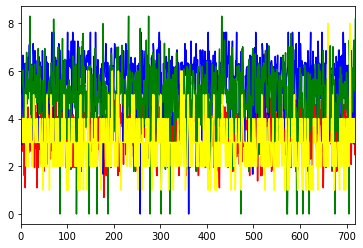

In [71]:
# plot each variables in one graph
temp.log_Age.plot(color = 'red')
temp.log_crime_C_average.plot(color = 'blue')
temp.root_travel_min_to_CBD.plot(color = 'green')
temp.Rooms.plot(color = 'yellow')

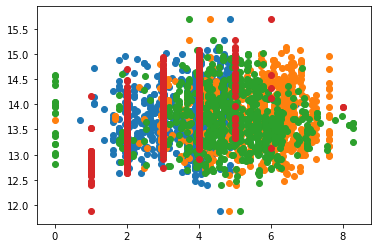

In [72]:
# for each column, plot the col - price scatter graph.
for col in ['log_Age','log_crime_C_average','root_travel_min_to_CBD','Rooms']:
    plt.scatter(temp[col], temp.log_Price)

According to the two graphs above, I think **applying log transformation in crime_C_average, Age, and Price**, **applying root transformation in travel_min_to_CBD** is a good choice.

#### Build up the model by parameters above using ols

In [73]:
model = sm.ols(formula="log_Price ~ log_Age \
+ log_crime_C_average\
+ root_travel_min_to_CBD\
+ Rooms"\
               ,data=temp).fit() # fit the model
print(model.summary()) # show details of the model

                            OLS Regression Results                            
Dep. Variable:              log_Price   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     136.7
Date:                Sun, 27 Oct 2019   Prob (F-statistic):           1.06e-86
Time:                        19:19:41   Log-Likelihood:                -390.03
No. Observations:                 720   AIC:                             790.1
Df Residuals:                     715   BIC:                             813.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 12

#### plot predicted values and real values(log_Price) in one graph


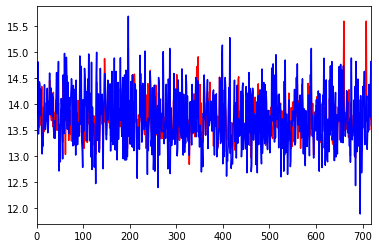

In [74]:
y_fitted = model.fittedvalues
y_fitted.plot(color='red')
temp.log_Price.plot(color='blue')

# Summary
<a id="summary"></a>

In this assignment, we learn how to integrate serveral dataets into one signle schema and fond and fix possible problems in the data by using Python 3. In addition, we use different normalization and transformation methods, such as standardization, min-max normalization, log, power, and root transformation on Rooms, crime_C_acerage, travel_min_to_CBD, and property_age to find which normalization/transformation method would work better to fit the linear model on price.